In [36]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import requests
import geopandas as gpd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Paths
PRICE_DATA_PATH = "../../data/raw/wfp/wfp_food_prices_eastern_africa_2019-2025_10countries_118487records.csv"
SPI_DATA_PATH = "../../data/processed/spi/06_spi_csv/east_africa_spi_gamma_6_month_with_boundaries.csv"
CACHE_FILE = "../../data/processed/admin2_temp_cache.csv"
# 1. Load Price Data
print("Loading Price Data...")
if not os.path.exists(PRICE_DATA_PATH):
    print(f"Error: Price data not found at {PRICE_DATA_PATH}")
    

df_price = pd.read_csv(PRICE_DATA_PATH)
df_price['date'] = pd.to_datetime(df_price['date'])
print(f"Columns: {df_price.columns}")

# Standardize Units
def extract_weight(unit_str):
    try:
        unit_str = str(unit_str).lower()
        if 'kg' in unit_str:
            numeric_part = ''.join([c for c in unit_str if c.isdigit() or c == '.'])
            if numeric_part:
                return float(numeric_part)
            return 1.0 # Default to 1 if just "KG"
        elif 'l' in unit_str: 
            numeric_part = ''.join([c for c in unit_str if c.isdigit() or c == '.'])
            if numeric_part:
                return float(numeric_part)
            return 1.0 
    except:
        pass
    return None

Loading Price Data...
Columns: Index(['countryiso3', 'date', 'admin1', 'admin2', 'market', 'market_id',
       'latitude', 'longitude', 'category', 'commodity', 'commodity_id',
       'unit', 'priceflag', 'pricetype', 'currency', 'price', 'usdprice'],
      dtype='object')


In [104]:
df_price[['countryiso3', 'admin2','market']].drop_duplicates().groupby(['countryiso3', 'admin2','market']).size().agg(['count'])

count    677
dtype: int64

In [62]:

df_price['weight_kg'] = df_price['unit'].apply(extract_weight)
df_price = df_price[df_price['weight_kg'] > 0].copy()
df_price['price_per_kg'] = df_price['usdprice'] / df_price['weight_kg']

print(f"Price Data Loaded: {df_price.shape}")

# Filter for key commodities
target_commodities = ['Maize', 'Sorghum', 'Wheat', 'Rice', 'Beans', 'Teff']
mask = df_price['commodity'].apply(lambda x: any(c in x for c in target_commodities))
df_price = df_price[mask].copy()

# Simplify Commodity Names
def simplify_name(name):
    for c in target_commodities:
        if c in name: return c
    return name
df_price['commodity_group'] = df_price['commodity'].apply(simplify_name)

# Select key columns & Aggregate
# Use 'countryiso3' instead of 'country'
price_clean = df_price[['countryiso3', 'admin1', 'admin2', 'market', 'latitude', 'longitude', 'date', 'commodity_group', 'price_per_kg']].copy()
# Rename for consistency
price_clean.rename(columns={'countryiso3': 'country_iso'}, inplace=True)

admin2_price = price_clean.groupby(['country_iso', 'admin2', 'date', 'commodity_group'])['price_per_kg'].mean().reset_index()

print(f"Aggregated Admin2 Price Data: {admin2_price.shape}")



Price Data Loaded: (77062, 20)
Aggregated Admin2 Price Data: (48296, 5)


In [82]:
admin2_price['country_iso'].unique()

array(['BDI', 'DJI', 'ETH', 'KEN', 'MDG', 'RWA', 'SOM', 'SSD', 'TZA',
       'UGA'], dtype=object)

In [64]:

# 2. Load & Aggregate SPI Data
print("Loading SPI Data (6-month)...")
if not os.path.exists(SPI_DATA_PATH):
    print(f"Error: SPI data not found at {SPI_DATA_PATH}")
    

try:
    cols_to_use = ['lat', 'lon', 'time', 'spi_gamma_6_month', 'country_iso', 'admin2']
    # Read a sample first or optimized read if too large. For now, try standard read.
    df_spi = pd.read_csv(SPI_DATA_PATH, usecols=cols_to_use)
    df_spi['date'] = pd.to_datetime(df_spi['time'])
    df_spi = df_spi.dropna(subset=['admin2'])
    
    # Calculate Centroids
    admin2_centroids = df_spi.groupby(['country_iso', 'admin2'])[['lat', 'lon']].mean().reset_index()
    
    # Aggregate SPI
    admin2_spi = df_spi.groupby(['country_iso', 'admin2', 'date'])['spi_gamma_6_month'].mean().reset_index()
    admin2_spi.rename(columns={'spi_gamma_6_month': 'spi_6m'}, inplace=True)
    
    print(f"Aggregated SPI Data: {admin2_spi.shape}")
    
except Exception as e:
    print(f"Error loading SPI: {e}")
    


# 3. Load Temperature Data - SKIPPED AS PER USER REQUEST
print("Skipping Temperature Data...")

# 4. Merge Data
print("Merging Datasets...")

# DEBUG: Check keys
print("Price Dates (Sample):", admin2_price['date'].head().values)
print("SPI Dates (Sample):", admin2_spi['date'].head().values)

# Normalize dates to 1st of month if needed
admin2_price['date'] = admin2_price['date'].dt.to_period('M').dt.to_timestamp()
admin2_spi['date'] = admin2_spi['date'].dt.to_period('M').dt.to_timestamp()

print("Normalized Dates.")
print("Price Admin2s:", admin2_price['admin2'].nunique())
print("SPI Admin2s:", admin2_spi['admin2'].nunique())

# Check intersection
common_admins = set(admin2_price['admin2']).intersection(set(admin2_spi['admin2']))
print(f"Common Admin2s: {len(common_admins)}")

# Merge Price + SPI
merged_df = pd.merge(admin2_price, admin2_spi, on=['country_iso', 'admin2', 'date'], how='inner') 
print(f"Merge (Price+SPI) Size: {merged_df.shape}")

if merged_df.empty:
    print("DEBUG: Merge failed. Check Country ISOs or Dates.")
    print("Price ISOs:", admin2_price['country_iso'].unique())
    print("SPI ISOs:", admin2_spi['country_iso'].unique())

# Drop rows with missing critical data
model_df = merged_df.dropna(subset=['price_per_kg', 'spi_6m']).copy()

print(f"Merged Dataset Size: {model_df.shape}")


# 5. Feature Engineering
print("Feature Engineering...")
model_df.sort_values(['country_iso', 'admin2', 'commodity_group', 'date'], inplace=True)

# Lags
for lag in [1, 2, 3, 6]:
    model_df[f'price_lag_{lag}'] = model_df.groupby(['country_iso', 'admin2', 'commodity_group'])['price_per_kg'].shift(lag)

model_df['month'] = model_df['date'].dt.month
model_df = model_df.dropna()

print(f"Final Model Dataset: {model_df.shape}")

# Save processed dataset for inspection
# model_df = pd.read_csv("../../data/processed/admin2_model_dataset.csv")


Loading SPI Data (6-month)...
Aggregated SPI Data: (582216, 4)
Skipping Temperature Data...
Merging Datasets...
Price Dates (Sample): ['2019-01-15T00:00:00.000000000' '2019-01-15T00:00:00.000000000'
 '2019-01-15T00:00:00.000000000' '2019-02-15T00:00:00.000000000'
 '2019-02-15T00:00:00.000000000']
SPI Dates (Sample): ['1991-01-01T00:00:00.000000000' '1991-02-01T00:00:00.000000000'
 '1991-03-01T00:00:00.000000000' '1991-04-01T00:00:00.000000000'
 '1991-05-01T00:00:00.000000000']
Normalized Dates.
Price Admin2s: 358
SPI Admin2s: 1387
Common Admin2s: 171
Merge (Price+SPI) Size: (25629, 6)
Merged Dataset Size: (25629, 6)
Feature Engineering...
Final Model Dataset: (21807, 11)


In [51]:
# model_df = pd.read_csv("../../data/processed/admin2_model_dataset.csv")
model_df.to_csv("../../data/processed/admin2_model_dataset.csv", index=False)


model_df

,country_iso,admin2,date,commodity_group,price_per_kg,spi_6m,price_lag_1,price_lag_2,price_lag_3,price_lag_6,month
25,BDI,Bisoro,2019-08-01,Beans,0.450,-0.206168,0.490,0.410,0.580,0.73,8
30,BDI,Bisoro,2019-10-01,Beans,0.510,1.429988,0.450,0.490,0.410,0.57,10
35,BDI,Bisoro,2019-11-01,Beans,0.590,1.981717,0.510,0.450,0.490,0.67,11
36,BDI,Bisoro,2019-12-01,Beans,0.580,1.931400,0.590,0.510,0.450,0.58,12
40,BDI,Bisoro,2020-01-01,Beans,0.610,1.875191,0.580,0.590,0.510,0.41,1
...,...,...,...,...,...,...,...,...,...,...,...
35334,UGA,Terego,2024-08-01,Sorghum,0.585,-0.436876,0.500,0.540,0.530,0.56,8
35338,UGA,Terego,2024-09-01,Sorghum,0.500,0.679817,0.585,0.500,0.540,0.53,9
35342,UGA,Terego,2024-10-01,Sorghum,0.570,1.099581,0.500,0.585,0.500,0.51,10
35346,UGA,Terego,2024-11-01,Sorghum,0.410,1.325025,0.570,0.500,0.585,0.53,11


In [ ]:
model_df['admin2', ]

,country_iso,date,commodity_group,price_per_kg,spi_6m,price_lag_1,price_lag_2,price_lag_3,price_lag_6,month
admin2,,,,,,,,,,
0,49,49,49,49,49,49,49,49,49,49
1,86,86,86,86,86,86,86,86,86,86
2,4,4,4,4,4,4,4,4,4,4
3,84,84,84,84,84,84,84,84,84,84
4,158,158,158,158,158,158,158,158,158,158
...,...,...,...,...,...,...,...,...,...,...
161,205,205,205,205,205,205,205,205,205,205
162,71,71,71,71,71,71,71,71,71,71
163,58,58,58,58,58,58,58,58,58,58


In [94]:
model_df_encoded = model_df.copy()
mappings = {}

for col in categorical_cols:
    cat = model_df_encoded[col].astype("category")
    mappings[col] = dict(enumerate(cat.cat.categories))
    model_df_encoded[col] = cat.cat.codes

In [ ]:


model_df.dropna()
features = ['spi_6m','month','commodity_group','country_iso','admin2', 'price_lag_2', 'price_lag_3', 'price_lag_6']
target = 'price_per_kg'

split_date = '2024-01-01'
train = model_df[model_df['date'] < split_date]
test = model_df[model_df['date'] >= split_date]

if train.empty or test.empty:
    print("Error: Train or Test set is empty. Check dates or data availability.")
    

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("--- Model Performance ---")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_preds)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, test_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

# Feature Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Feature Importance ---")
print(importances)

model_df

Training Model...
--- Model Performance ---
Train RMSE: 2.5455
Test RMSE: 0.5744
Test MAE: 0.2440
Test R2: 0.6011

--- Feature Importance ---
price_lag_2        0.607053
price_lag_3        0.109121
spi_6m             0.092053
month              0.073611
price_lag_6        0.040453
commodity_group    0.039759
admin2             0.024917
country_iso        0.013033
dtype: float64


,country_iso,admin2,date,commodity_group,price_per_kg,spi_6m,price_lag_1,price_lag_2,price_lag_3,price_lag_6,month
19,0,12,2019-08-01,0,0.450,-0.206168,0.490,0.410,0.580,0.73,8
23,0,12,2019-10-01,0,0.510,1.429988,0.450,0.490,0.410,0.57,10
27,0,12,2019-11-01,0,0.590,1.981717,0.510,0.450,0.490,0.67,11
28,0,12,2019-12-01,0,0.580,1.931400,0.590,0.510,0.450,0.58,12
31,0,12,2020-01-01,0,0.610,1.875191,0.580,0.590,0.510,0.41,1
...,...,...,...,...,...,...,...,...,...,...,...
25617,7,159,2024-08-01,3,0.585,-0.436876,0.500,0.540,0.530,0.56,8
25620,7,159,2024-09-01,3,0.500,0.679817,0.585,0.500,0.540,0.53,9
25623,7,159,2024-10-01,3,0.570,1.099581,0.500,0.585,0.500,0.51,10
25626,7,159,2024-11-01,3,0.410,1.325025,0.570,0.500,0.585,0.53,11


(array([1.7313e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e-02, 6.487950e+01, 1.297490e+02, 1.946185e+02,
        2.594880e+02, 3.243575e+02, 3.892270e+02, 4.540965e+02,
        5.189660e+02, 5.838355e+02, 6.487050e+02]),
 <BarContainer object of 10 artists>)

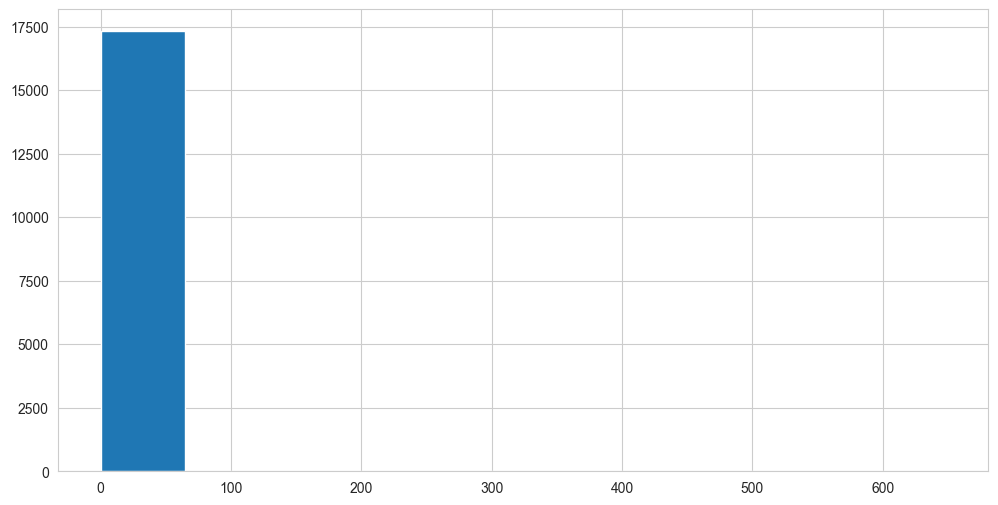

In [87]:
plt.hist(train[target])

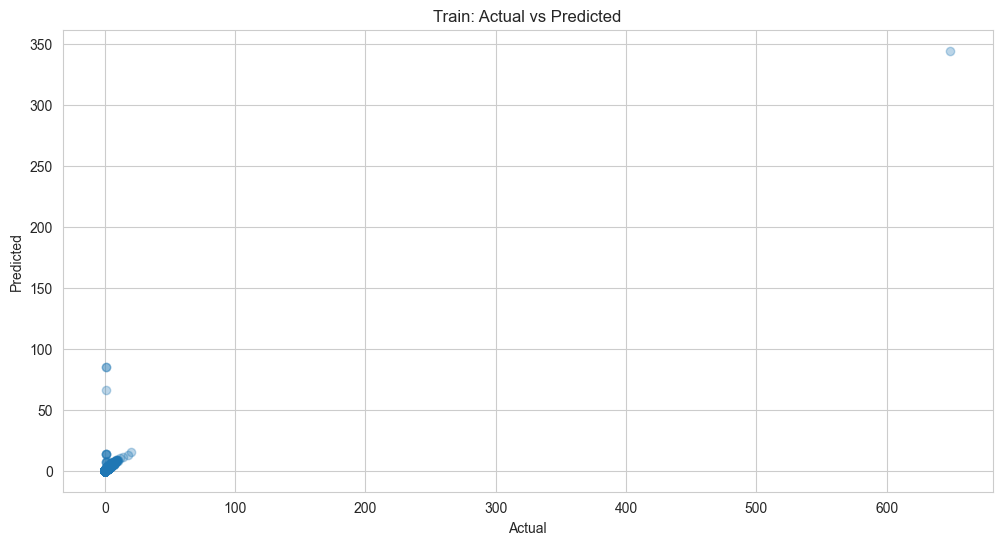

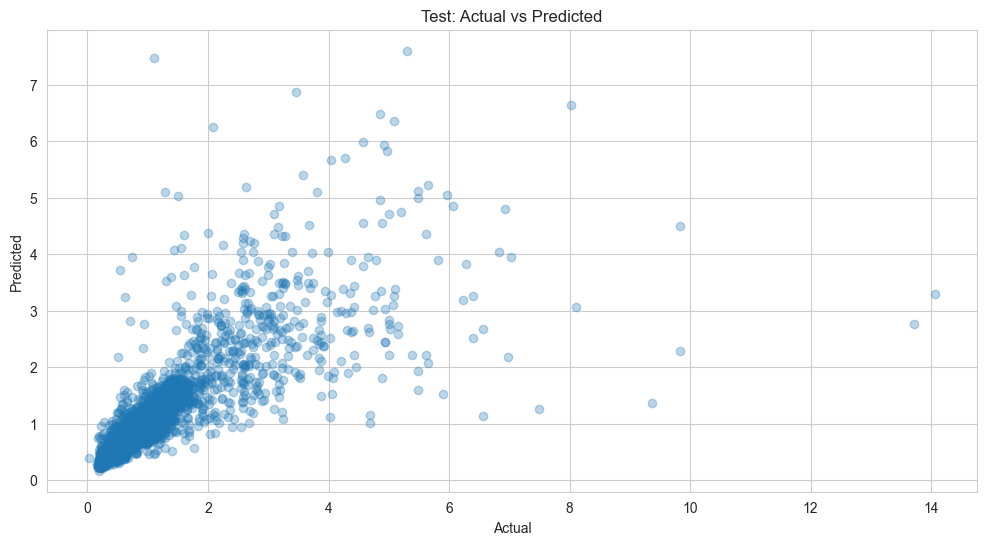

In [70]:
plt.figure()
plt.scatter(y_train, train_preds, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Train: Actual vs Predicted")
plt.show()

plt.figure()
plt.scatter(y_test, test_preds, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test: Actual vs Predicted")
plt.show()

In [71]:
import matplotlib.pyplot as plt

# copy로 경고 방지
train_vis = train.copy()
test_vis = test.copy()

train_vis["pred"] = train_preds
test_vis["pred"] = test_preds

train_vis["resid"] = train_vis[target] - train_vis["pred"]
test_vis["resid"] = test_vis[target] - test_vis["pred"]

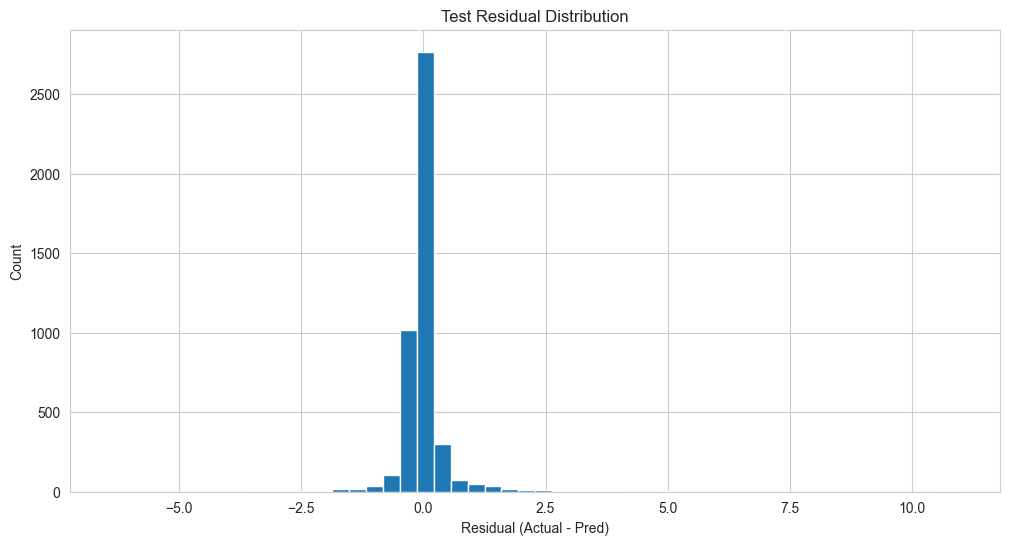

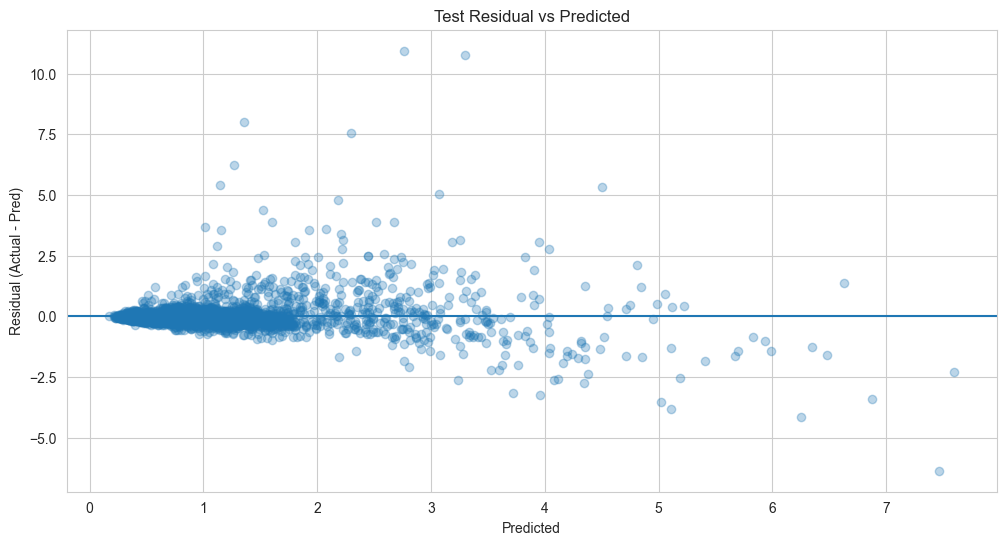

In [72]:
plt.figure()
plt.hist(test_vis["resid"].dropna(), bins=50)
plt.xlabel("Residual (Actual - Pred)")
plt.ylabel("Count")
plt.title("Test Residual Distribution")
plt.show()

plt.figure()
plt.scatter(test_vis["pred"], test_vis["resid"], alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Pred)")
plt.title("Test Residual vs Predicted")
plt.show()

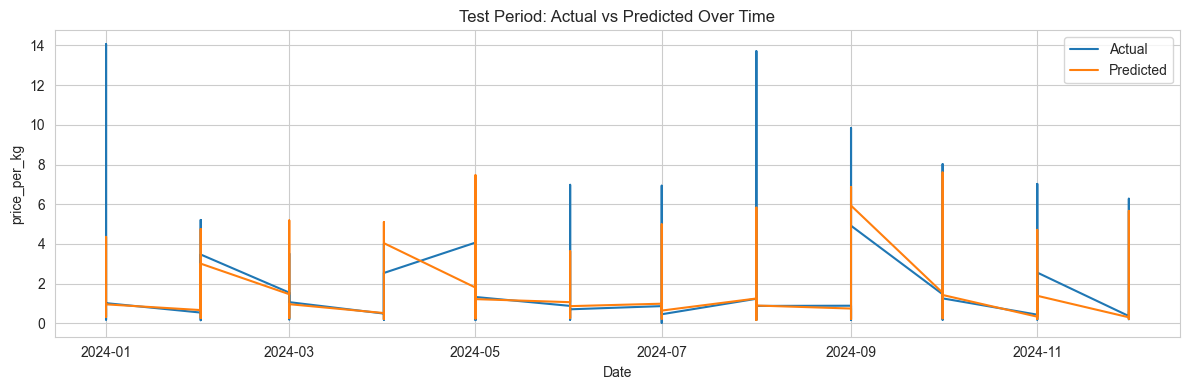

In [73]:
# date가 문자열이면 datetime으로
test_vis["date"] = pd.to_datetime(test_vis["date"])
test_vis = test_vis.sort_values("date")

plt.figure(figsize=(12,4))
plt.plot(test_vis["date"], test_vis[target], label="Actual")
plt.plot(test_vis["date"], test_vis["pred"], label="Predicted")
plt.xlabel("Date")
plt.ylabel(target)
plt.title("Test Period: Actual vs Predicted Over Time")
plt.legend()
plt.tight_layout()
plt.show()

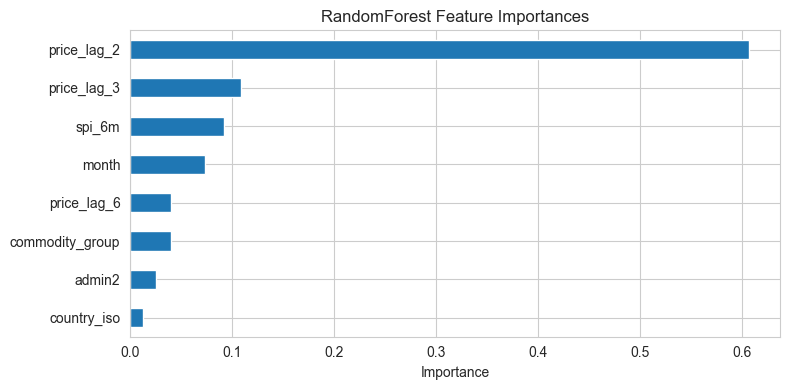

In [95]:
plt.figure(figsize=(8,4))
importances.sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}


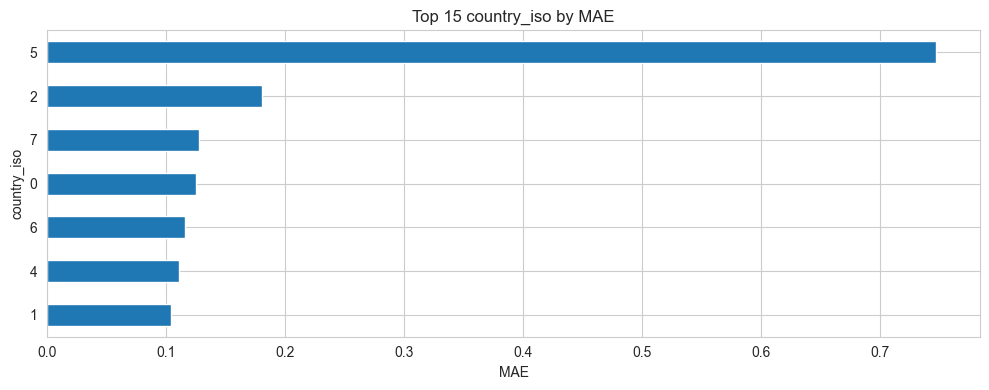

In [96]:
print(mappings["country_iso"])

group_mae_named = group_mae.rename(index=mappings["country_iso"])
group_mae_named.sort_values().plot(kind="barh", figsize=(10,4))
plt.xlabel("MAE")
plt.title("Top 15 country_iso by MAE")
plt.tight_layout()
plt.show()

In [79]:
pd.read_csv("PRICE_DATA_PATH")

FileNotFoundError: [Errno 2] No such file or directory: 'PRICE_DATA_PATH'